Meeting 1

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4130 sha256=61e25f72c35e3c6aa6a7b83ea90647988253db0de6c4086482dbe643ee702ad0
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


Carga y Exploración de datos

Cargar datos, después hay otra carga porque al parecer en lo que hacemos la exploración el archivo se corrompe.

In [ ]:
data = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/td_ztf_stamp_17_06_20.pkl')

In [ ]:
print(data.keys())

dict_keys(['Train', 'Validation', 'Test'])


In [ ]:
train_data = data["Train"]

# Si train_data es un DataFrame:
if isinstance(train_data, pd.DataFrame):
    print(train_data.head())
    print(train_data.info())
else:
    print(type(train_data))  # Esto imprimirá el tipo de objeto que es train_data si no es un DataFrame.

<class 'dict'>


In [ ]:
print(train_data.keys())

dict_keys(['images', 'labels', 'features'])


In [ ]:
# Explorar imágenes
for i in range(5):  # Mostrar las primeras 5 imágenes
    plt.imshow(train_data['images'][i])
    plt.title(f"Label: {train_data['labels'][i]}")
    plt.show()

# Estadísticas de las etiquetas
print(pd.Series(train_data['labels']).value_counts())

print(pd.DataFrame(train_data['features']).describe())

1. **Imágenes**: Se mostraron las primeras 5 imágenes del conjunto de entrenamiento.

2. **Estadísticas de las etiquetas**: Se observan 5 clases (0, 1, 2, 3 y 4) y todas están equilibradas, ya que cada clase tiene 14542 ejemplos. Esto es bueno porque no hay un desequilibrio de clases que pueda sesgar el modelo.

3. **Estadísticas de las características**: Hay un total de 26 características (0 a 25). Las estadísticas muestran el `count` (conteo), `unique` (valores únicos), `top` (valor más común) y `freq` (frecuencia del valor más común). Algunas observaciones:

   - La característica 6 parece tener solo 2 valores únicos, lo que sugiere que podría ser binaria.
   - Algunas características tienen muchos valores únicos, lo que sugiere que son continuas o categóricas con muchos niveles.
   - El valor más común y su frecuencia para cada característica pueden dar una idea de si hay alguna característica que tenga un valor dominante. Por ejemplo, para la característica 6, el valor más común es 0.0 con una frecuencia de 54818, lo que es un indicador fuerte de que es una característica binaria.

# Arquitectura del modelo (fallida)

In [ ]:
class CustomNet(nn.Module):
    def __init__(self):
        super(CustomNet, self).__init__()

        # Convolutional Layers
        self.conv1 = nn.Conv2d(3, 32, 4)
        self.conv2 = nn.Conv2d(32, 32, 3)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.conv4 = nn.Conv2d(64, 64, 3)
        self.conv5 = nn.Conv2d(64, 64, 3)
        self.pool2 = nn.MaxPool2d(2, 2)

        # Fully connected layers
        self.fc1 = nn.Linear(2304, 64)  # Aquí también en base a las pruebas hicimos una modificación más abajo
        self.fc2 = nn.Linear(64 + 23, 64)  # 23 es el feature size en el paper, modificar si es diferente (más abajo lo cambiamos a 90 ya que hay 26 features como vimos anteriormente)
        self.dropout = nn.Dropout(0.5)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 5)

    def forward(self, x, features):
        # CNN
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.pool2(x)

        # Flatten
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = torch.cat((x, features), 1)  # Concatenar features
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)

        return x

net = CustomNet()
print(net)

CustomNet(
  (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2304, out_features=64, bias=True)
  (fc2): Linear(in_features=87, out_features=64, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=64, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=5, bias=True)
)


Cargamos denuevo el dataset porque hay una especie de corrupción que no nos deja seguir adelante con el cargado anteriormente.

In [ ]:
import pickle

with open('/content/drive/MyDrive/Colab Notebooks/td_ztf_stamp_17_06_20.pkl', 'rb') as file:
    data = pickle.load(file)

print(type(data))
print(data.keys())

<class 'dict'>
dict_keys(['Train', 'Validation', 'Test'])


Aquí seguimos explorando las características de los datos ya que la arquitectura presenta errores que no nos permite entrenar el modelo.

In [ ]:
sample_input = train_data['images'][0]
print(type(sample_input))
print(sample_input)

In [ ]:
sample_tensor = torch.tensor(sample_input).float()#.cuda()
print(sample_tensor.size())

torch.Size([63, 63, 3])


In [ ]:
sample_tensor = sample_tensor.permute(2, 0, 1).unsqueeze(0)
print(sample_tensor.size())

torch.Size([1, 3, 63, 63])


Aquí nos damos cuenta que hay que cambiar a 90 (64+26) la arquitectura del paper.

In [ ]:
for i, feature in enumerate(train_data['features']):
    print(i, type(feature), feature.shape)

In [ ]:
sample_feature = train_data['features'][0]  # Usamos el primer elemento como ejemplo.
for i, item in enumerate(sample_feature):
    print(f"Element {i} is of type {type(item)}")

In [ ]:
for i in range(len(train_data['images'])):
    inputs = torch.tensor(train_data['images'][i]).float().cuda().permute(2, 0, 1).unsqueeze(0)

    feature_array = train_data['features'][i]

    try:
        features_tensor = torch.tensor(feature_array).float().cuda().unsqueeze(0)
    except TypeError as e:
        print(f"Error with feature at index {i}: {feature_array}")
        raise e

    labels = torch.tensor(train_data['labels'][i]).long().cuda().unsqueeze(0)

In [ ]:
features_tensor = torch.tensor(feature_array.astype(np.float64)).float().cuda().unsqueeze(0)

In [ ]:
print(inputs.shape)

torch.Size([1, 3, 63, 63])


# Arquitectura 2 (datos de nuestro dataset)

In [ ]:
class CustomNet(nn.Module):
    def __init__(self):
        super(CustomNet, self).__init__()

        # Capas de convolución
        self.conv1 = nn.Conv2d(3, 32, 4)
        self.conv2 = nn.Conv2d(32, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.conv4 = nn.Conv2d(64, 64, 3)
        self.conv5 = nn.Conv2d(64, 64, 3)

        # Capas de pooling
        self.pool1 = nn.MaxPool2d(2, 2)
        self.pool2 = nn.MaxPool2d(2, 2)

        # Capas totalmente conectadas
        self.fc1 = nn.Linear(7744, 64) # En base a nuestras pruebas nos damos cuenta que con nuestros datos este es el número que recibe, en lugar de 2304.
        self.fc2 = nn.Linear(90, 64)   #90(64+26)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 5)  # 5 clases

    def forward(self, x, features):
        # Pasamos por la primera capa convolucional
        x = F.relu(self.conv1(x))
        print(f"Después de conv1: {x.shape}")

        # Pasamos por la segunda capa convolucional
        x = F.relu(self.conv2(x))
        print(f"Después de conv2: {x.shape}")

        # Aplicamos max pooling
        x = self.pool1(x)
        print(f"Después de pool1: {x.shape}")

        # Tercera capa convolucional
        x = F.relu(self.conv3(x))
        print(f"Después de conv3: {x.shape}")

        # Cuarta capa convolucional
        x = F.relu(self.conv4(x))
        print(f"Después de conv4: {x.shape}")

        # Quinta capa convolucional
        x = F.relu(self.conv5(x))
        print(f"Después de conv5: {x.shape}")

        # Segundo max pooling
        x = self.pool2(x)
        print(f"Después de pool2: {x.shape}")

        # Aplanamos el tensor
        x = x.view(x.size(0), -1)
        print(f"Después de aplanar: {x.shape}")

        # Pasamos por la primera capa totalmente conectada
        x = F.relu(self.fc1(x))
        print(f"Después de fc1: {x.shape}")

        # Concatenamos con las características adicionales
        x = torch.cat((x, features), dim=1)
        print(f"Después de concatenar: {x.shape}")

        # Pasamos por las siguientes capas totalmente conectadas
        x = F.relu(self.fc2(x))
        print(f"Después de fc2: {x.shape}")

        x = F.relu(self.fc3(x))
        print(f"Después de fc3: {x.shape}")

        x = self.fc4(x)
        print(f"Después de fc4: {x.shape}")

        return x

# Instanciamos el modelo
net = CustomNet().cuda()

Entrenamiento (+- 2hrs)

In [ ]:
# Define el criterio y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

for epoch in range(10):  # Vamos a hacer 10 épocas para simplificar
    running_loss = 0.0

    for i in range(len(train_images)):
        # Obtiene los datos
        inputs = train_images[i]
        features_tensor = train_features[i]
        labels = train_labels[i]

        # Pone a cero los gradientes del optimizador
        optimizer.zero_grad()

        # Propagación hacia adelante, retropropagación y optimización
        outputs = net(inputs, features_tensor)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Imprime las estadísticas
        running_loss += loss.item()
        if i % 2000 == 1999:  # Imprime cada 2000 mini-batches
            print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 2000:.3f}")
            running_loss = 0.0

print("¡Entrenamiento terminado!")

Se truncaron las últimas líneas 5000 del resultado de transmisión.
Después de pool2: torch.Size([1, 64, 11, 11])
Después de aplanar: torch.Size([1, 7744])
Después de fc1: torch.Size([1, 64])
Después de concatenar: torch.Size([1, 90])
Después de fc2: torch.Size([1, 64])
Después de fc3: torch.Size([1, 64])
Después de fc4: torch.Size([1, 5])
Después de conv1: torch.Size([1, 32, 60, 60])
Después de conv2: torch.Size([1, 32, 58, 58])
Después de pool1: torch.Size([1, 32, 29, 29])
Después de conv3: torch.Size([1, 64, 27, 27])
Después de conv4: torch.Size([1, 64, 25, 25])
Después de conv5: torch.Size([1, 64, 23, 23])
Después de pool2: torch.Size([1, 64, 11, 11])
Después de aplanar: torch.Size([1, 7744])
Después de fc1: torch.Size([1, 64])
Después de concatenar: torch.Size([1, 90])
Después de fc2: torch.Size([1, 64])
Después de fc3: torch.Size([1, 64])
Después de fc4: torch.Size([1, 5])
Después de conv1: torch.Size([1, 32, 60, 60])
Después de conv2: torch.Size([1, 32, 58, 58])
Después de pool1:

Guardar el modelo

In [ ]:
torch.save(net.state_dict(), 'model_weights.pth') #Entorno actual

In [ ]:
from google.colab import files    #Descargar
files.download('model_weights.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Cargar el modelo descargado (por si se nos desconecta colab)

In [ ]:
from google.colab import files  #cargar el archivo
uploaded = files.upload()

Saving model_weights.pth to model_weights.pth


In [ ]:
net.load_state_dict(torch.load('model_weights.pth')) #cargar el modelo entrenado con gpu (nuestro caso)

<All keys matched successfully>

In [ ]:
net.load_state_dict(torch.load('model_weights.pth', map_location=torch.device('cpu'))) #Cargar el modelo a entorno sin gpu (cuando se nos acaba el límite en colab)

<All keys matched successfully>

Evaluación y Ajustes

In [ ]:
net.eval()

CustomNet(
  (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=7744, out_features=64, bias=True)
  (fc2): Linear(in_features=90, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=5, bias=True)
)

Accuracy

In [ ]:
correct = 0
total = 0
all_labels = []
all_predictions = []

with torch.no_grad():
    for i in range(len(data['Validation']['images'])):
        images = torch.tensor(data['Validation']['images'][i]).float().cuda().permute(2, 0, 1).unsqueeze(0)   #Con GPU
        features = torch.tensor(np.array(data['Validation']['features'][i], dtype=np.float32)).float().cuda().unsqueeze(0)
        labels = torch.tensor(data['Validation']['labels'][i]).long().cuda().unsqueeze(0)

        outputs = net(images, features)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

print('Accuracy of the network on the validation images: %d %%' % (100 * correct / total))

RuntimeError: ignored

In [ ]:
correct = 0
total = 0
all_labels = []
all_predictions = []

with torch.no_grad():
    for i in range(len(data['Validation']['images'])):
        images = torch.tensor(data['Validation']['images'][i]).float().permute(2, 0, 1).unsqueeze(0)    #Sin GPU
        features = torch.tensor(np.array(data['Validation']['features'][i], dtype=np.float32)).float().unsqueeze(0)
        labels = torch.tensor(data['Validation']['labels'][i]).long().unsqueeze(0)

        outputs = net(images, features)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_labels.extend(labels.numpy())
        all_predictions.extend(predicted.numpy())

print('Accuracy of the network on the validation images: %d %%' % (100 * correct / total))

Se truncaron las últimas líneas 5000 del resultado de transmisión.
Después de pool2: torch.Size([1, 64, 11, 11])
Después de aplanar: torch.Size([1, 7744])
Después de fc1: torch.Size([1, 64])
Después de concatenar: torch.Size([1, 90])
Después de fc2: torch.Size([1, 64])
Después de fc3: torch.Size([1, 64])
Después de fc4: torch.Size([1, 5])
Después de conv1: torch.Size([1, 32, 60, 60])
Después de conv2: torch.Size([1, 32, 58, 58])
Después de pool1: torch.Size([1, 32, 29, 29])
Después de conv3: torch.Size([1, 64, 27, 27])
Después de conv4: torch.Size([1, 64, 25, 25])
Después de conv5: torch.Size([1, 64, 23, 23])
Después de pool2: torch.Size([1, 64, 11, 11])
Después de aplanar: torch.Size([1, 7744])
Después de fc1: torch.Size([1, 64])
Después de concatenar: torch.Size([1, 90])
Después de fc2: torch.Size([1, 64])
Después de fc3: torch.Size([1, 64])
Después de fc4: torch.Size([1, 5])
Después de conv1: torch.Size([1, 32, 60, 60])
Después de conv2: torch.Size([1, 32, 58, 58])
Después de pool1:

Matriz de confusión

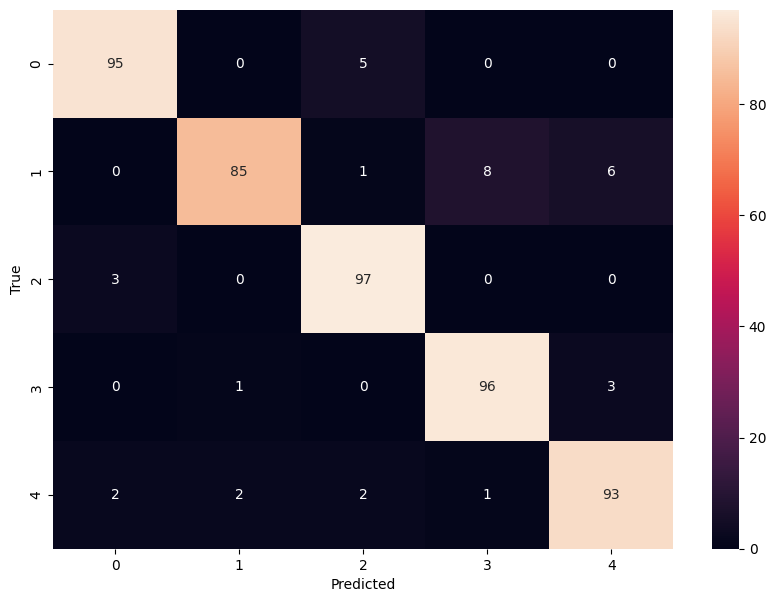

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(all_labels, all_predictions)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

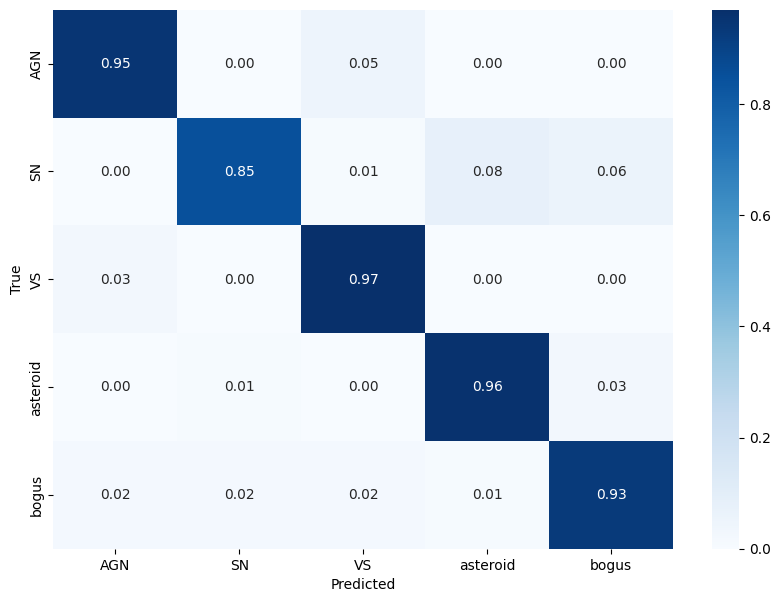

In [ ]:
import numpy as np

# Normaliza la matriz de confusión
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

labels = ['AGN', 'SN', 'VS', 'asteroid', 'bogus']

plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
from torchviz import make_dot

# Entrada de imagen de muestra
sample_image = torch.randn(1, 3, 63, 63)

# Entrada de características de muestra
sample_features = torch.randn(1, 26)

In [ ]:
# Mover el modelo a la CPU
net = net.cpu()

output = net(sample_image, sample_features)

# Generar diagrama
dot = make_dot(output)

# Visualiza el diagrama
dot.view()

Después de conv1: torch.Size([1, 32, 60, 60])
Después de conv2: torch.Size([1, 32, 58, 58])
Después de pool1: torch.Size([1, 32, 29, 29])
Después de conv3: torch.Size([1, 64, 27, 27])
Después de conv4: torch.Size([1, 64, 25, 25])
Después de conv5: torch.Size([1, 64, 23, 23])
Después de pool2: torch.Size([1, 64, 11, 11])
Después de aplanar: torch.Size([1, 7744])
Después de fc1: torch.Size([1, 64])
Después de concatenar: torch.Size([1, 90])
Después de fc2: torch.Size([1, 64])
Después de fc3: torch.Size([1, 64])
Después de fc4: torch.Size([1, 5])


'Digraph.gv.pdf'

In [ ]:
from google.colab import files
files.download('Digraph.gv.pdf')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from pdf2image import convert_from_path

images = convert_from_path('Digraph.gv.pdf')
for i, image in enumerate(images):
    image.save(f'output_image_{i}.png', 'PNG')

In [ ]:
from google.colab import files

files.download('output_image_0.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

| Semana | Actividades                                                                                   |
|--------|------------------------------------------------------------------------------------------------|
| 9-10   | - Investigación y estudio detallado papers de referencia.                         |
|        | - Presentación de resultados y arquitectura del modelo.                             |
|        | - Recepción de feedback y reconocimiento de áreas de mejora.                                  |
|        | - Identificación y preparación de datos y transformaciones requeridos (i.e. rotaciones). |
| 11     | - Implementación completa de la arquitectura basada en los papers.                              |
|        | - Evaluación inicial del modelo basado en los papers para establecer una línea base de rendimiento.      |
| 12     | - Tunning básico de hiperparámetros basados en el paper y en nuestras propias observaciones y necesidades.     |
|        | - Comparación de resultados entre modelos.            |
| 13     | - Identificación de posibles mejoras o ajustes a la arquitectura original.                    |
|        | - Implementación y evaluación de una o dos mejoras propuestas.                                |
| 14     | - Finalización de pruebas y evaluaciones.                                                     |
|        | - Preparación del informe final, enfocado en el proceso de "replicación" y las mejoras propuestas. |
| 15     | - Preparación y práctica de la presentación final.                                            |
|        | - Presentación de los resultados |
